# Explore baby name data

## Imports

In [2]:
import glob
import re

## Read in data

In [3]:
%%time
df = pd.concat([pd.read_csv(s, header=None).eval('year  =  %s' % re.findall('[0-9]{4}', s)[0]) for s in glob.glob('names/*txt')], )
df.columns = ['name', 'gender', 'count', 'year']
df = df.set_index(['year', 'name', 'gender']).sort_index()

CPU times: user 5.63 s, sys: 731 ms, total: 6.36 s
Wall time: 7.7 s


In [34]:
df.head()

count
year name    gender       
2000 Emily   F       25953
     Hannah  F       23080
     Madison F       19967
     Ashley  F       17997
     Sarah   F       17697

## Set up convenience function

In [44]:
df.xs('Emily', level='name').groupby('year').sum()['count'].idxmax()

1999

In [98]:
def get_name_series(name, center=False):
    name_series = df.xs(name, level='name').groupby('year').sum()
    if center:
        max_yr = name_series['count'].idxmax()
        name_series.index -= max_yr
        
    return name_series['count']

In [100]:
def plot_name_popularity(name, center=False):
    name_series = get_name_series(name)
    name_series.plot(ax=plt.gca())

In [148]:
def plot_top_names(year, gender, n=10):
    top_names =  (df.xs(year, level='year')
                    .xs(gender, level='gender')
                    .sort_values('count', ascending=False)
                    .head(n))

    top_names[::-1].plot.barh()
    plt.grid()
    ft_ax(title='Most popular names (%i, %s)' % (year, gender), left_axis=True)
    #return top_names[::-1]

## Visualize Data

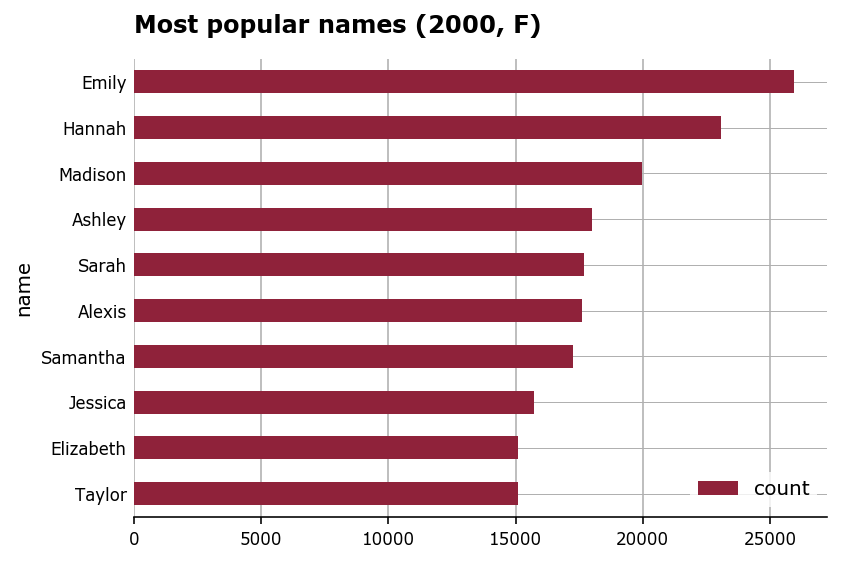

In [149]:
plot_top_names(2000, 'F')

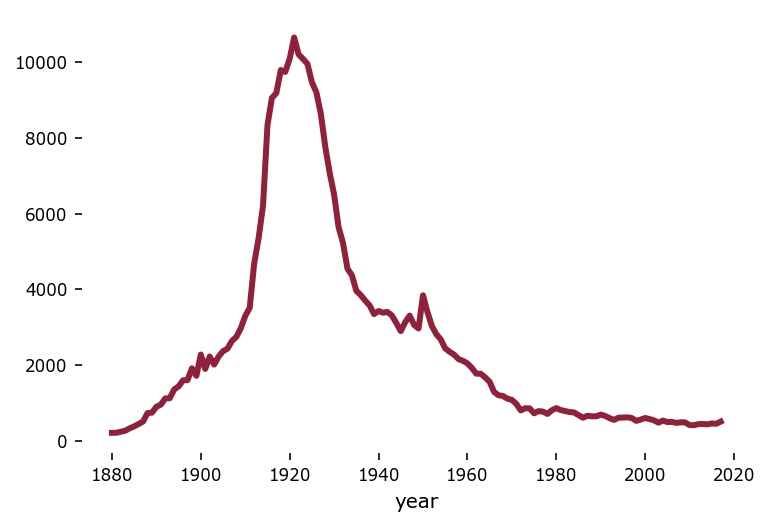

In [142]:
get_name_series('Irene').plot()

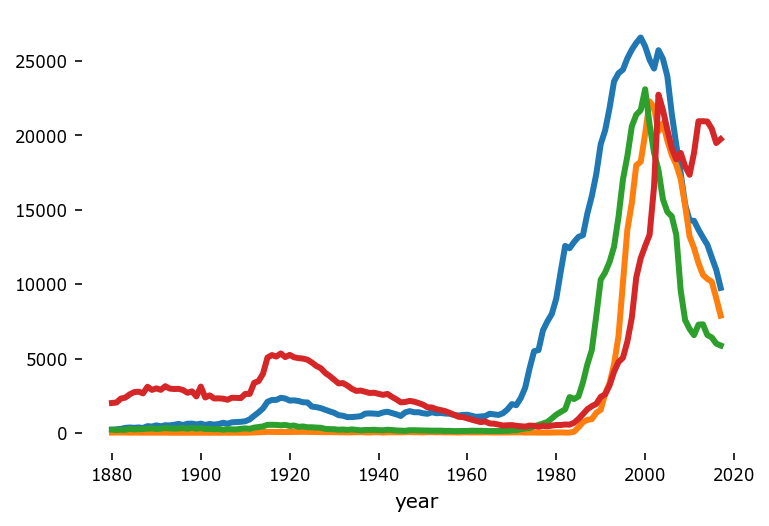

In [103]:
with sns.color_palette(tableau10):
    for name in ['Emily', 'Madison', 'Hannah', 'Emma']:
        plot_name_popularity(name, center=False)

In [128]:
name_series = get_name_series('Emily')

lag_df = name_series.to_frame("y")
lag_df['y_lag'] = name_series.shift()
lag_df['diff'] = (lag_df.y - lag_df.y_lag)
lag_df.dropna(inplace=True)

lm('diff ~ y_lag', data=lag_df)

                            OLS Regression Results                            
Dep. Variable:                   diff   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.4116
Date:                Thu, 25 Oct 2018   Prob (F-statistic):              0.522
Time:                        02:31:30   Log-Likelihood:                -1084.4
No. Observations:                 137   AIC:                             2173.
Df Residuals:                     135   BIC:                             2179.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     96.8435     71.071      1.363      0.1

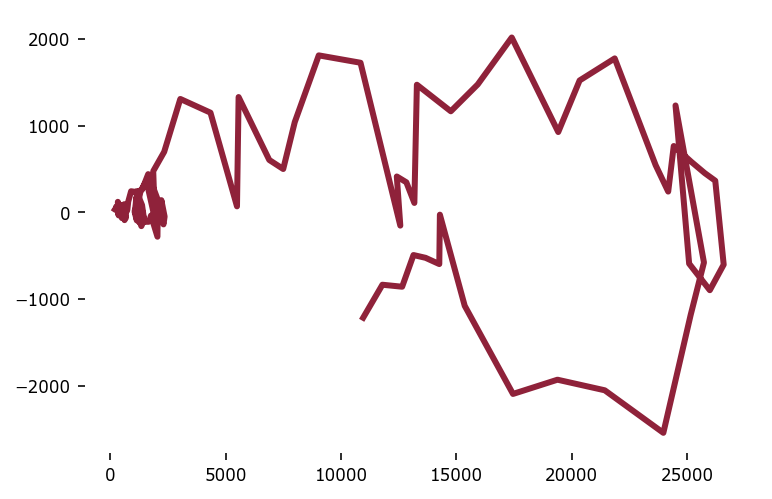

In [129]:
plt.plot(lag_df.y_lag, lag_df['diff'])

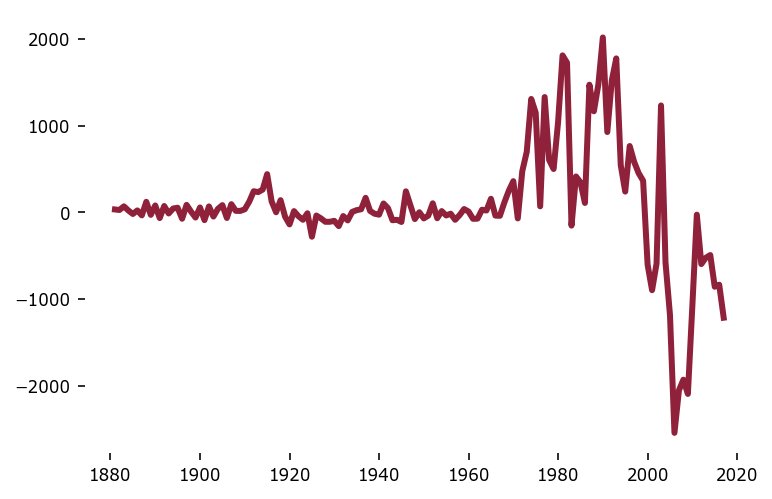

In [131]:
plt.plot(lag_df['diff'])